# Predicting Bounding Boxes

In this project, I build a model to predict bounding boxes around images.  
- I use transfer learning on the [Caltech Birds - 2010](http://www.vision.caltech.edu/visipedia/CUB-200.html) dataset.

In [1]:
import os, re, time, json, zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2


## Download and Extract the Dataset

In [2]:
  # Download the dataset
  !wget https://storage.googleapis.com/tensorflow-3-public/datasets/caltech_birds2010_011.zip

--2025-08-19 10:04:33--  https://storage.googleapis.com/tensorflow-3-public/datasets/caltech_birds2010_011.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.186.91, 142.250.186.155, 216.58.206.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.186.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688150437 (656M) [application/zip]
Saving to: ‘caltech_birds2010_011.zip’

caltech_birds2010_0 100%[===================>] 656.27M  9.16MB/s    in 77s     

2025-08-19 10:05:51 (8.50 MB/s) - ‘caltech_birds2010_011.zip’ saved [688150437/688150437]



In [3]:
# Specify the data directory
data_dir = "./data"

# Create the data directory
try:
  os.mkdir(data_dir)
except FileExistsError:
  print(f'{data_dir} already exists')

# Extract the dataset into the data directory
with zipfile.ZipFile('./caltech_birds2010_011.zip') as zipref:
  zipref.extractall(data_dir)

## Visualization Utilities
### Bounding Boxes Utilities

some functions which I use to draw bounding boxes around the birds in the `image`:

- `draw_bounding_box_on_image`: Draws a single bounding box on an image.
- `draw_bounding_boxes_on_image`: Draws multiple bounding boxes on an image.
- `draw_bounding_boxes_on_image_array`: Draws multiple bounding boxes on an array of images.

In [4]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.

    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """

    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.

    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).

    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)

    return image


### Data and Predictions Utilities

Some functions I use to visualize the data and the model's predictions:

- `display_digits_with_boxes`: This displays a row of "digit" images along with the model's predictions for each image.
- `plot_metrics`: This plots a given metric (like loss) as it changes over multiple epochs of training.  

In [5]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)

      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])

      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Preprocess and Load the Dataset
### Preprocessing Utilities
Here are some helper functions to pre-process the image data.

#### read_image_tfds
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [6]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x ,
                 bbox[1] / factor_y,
                 bbox[2] / factor_x ,
                 bbox[3] / factor_y]

    return image, bbox_list

#### read_image_with_shape
This is very similar to `read_image_tfds` except it also keeps a copy of the original image (before pre-processing) and returns this as well.
- Makes a copy of the original image.
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [7]:
def read_image_with_shape(image, bbox):
    original_image = image

    image, bbox_list = read_image_tfds(image, bbox)

    return original_image, image, bbox_list

#### read_image_tfds_with_original_bbox

- This function reads `image` from `data`
- It also denormalizes the bounding boxes (it undoes the bounding box normalization that is performed by the previous two helper functions.)

In [8]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x ,
                 bbox[0] * factor_y,
                 bbox[3] * factor_x,
                 bbox[2] * factor_y]
    return image, bbox_list

#### dataset_to_numpy_util
This function converts a `dataset` into numpy arrays of images and boxes.
- This will be used when visualizing the images and their bounding boxes

In [9]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)

    if N > 0:
        take_dataset = take_dataset.take(N)

    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())

    return (np.array(ds_images, dtype='object'), np.array(ds_bboxes, dtype='object'))

#### dataset_to_numpy_with_original_bboxes_util

- This function converts a `dataset` into numpy arrays of
  - original images
  - resized and normalized images
  - bounding boxes
- This will be used for plotting the original images with true and predicted bounding boxes.

In [10]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)

    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []

    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images, dtype='object'), np.array(ds_images, dtype='object'), np.array(ds_bboxes, dtype='object')


### Visualize the images and their bounding box labels
Now I take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.

Visualize the **training** images and their bounding box labels

2025-08-19 10:15:42.375687: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-08-19 10:15:42.375940: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-08-19 10:15:42.375954: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-08-19 10:15:42.376247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-19 10:15:42.376266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_dir='./data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'segmentation_mask': Imag

2025-08-19 10:15:42.814667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


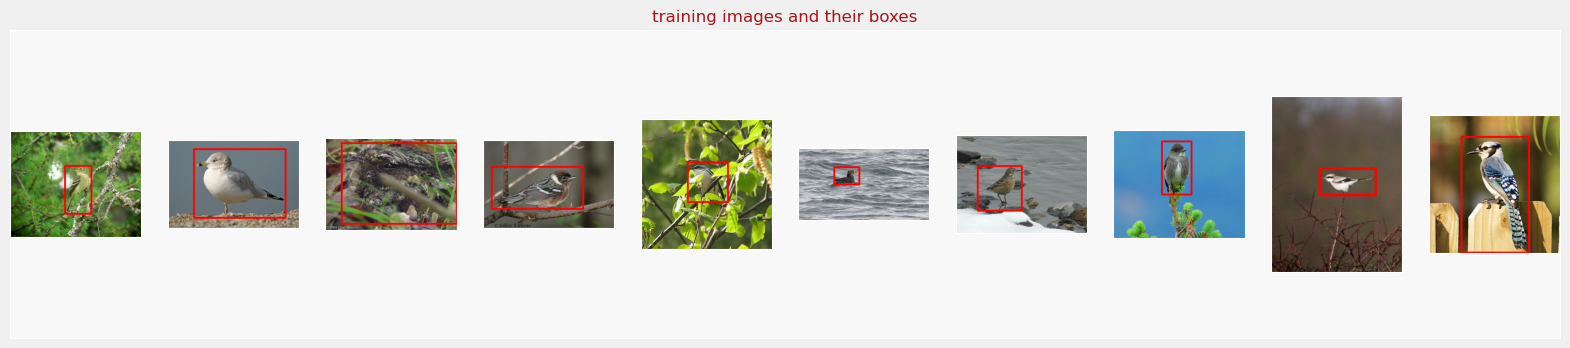

In [11]:
def get_visualization_training_dataset():
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox,
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their boxes")

Visualize the **validation** images and their bounding boxes

2025-08-19 10:16:25.086202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


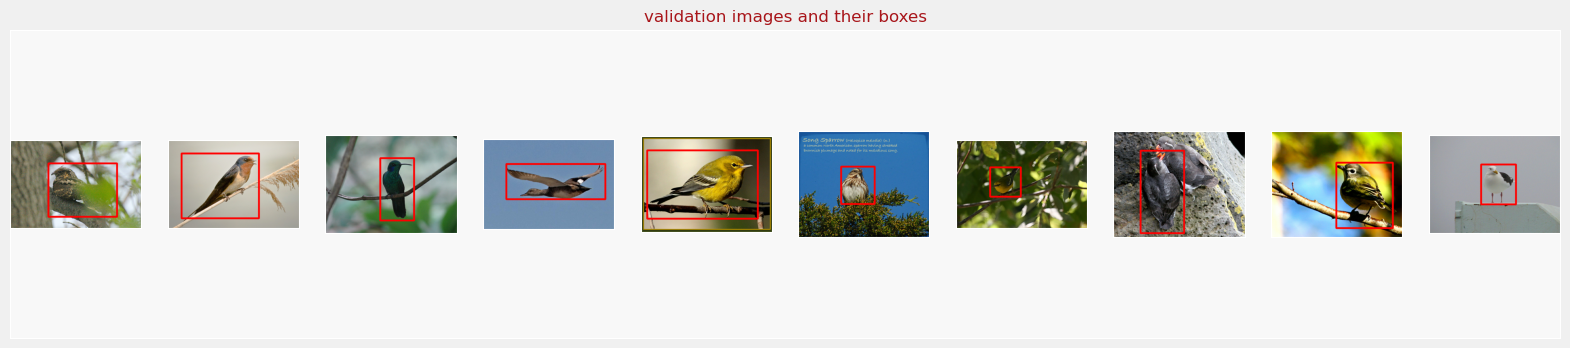

In [12]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their boxes")


### Load and prepare the datasets for the model

These next two functions read and prepare the datasets that I feed to the model.
- They use `read_image_tfds` to resize, and normalize each image and its bounding box label.
- They performs shuffling and batching.
- I use these functions to create `training_dataset` and `validation_dataset`, which I give to the model.

In [13]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)


## Define the Network

Bounding box prediction is treated as a "regression" task, in that I want the model to output numerical values.

- I perform transfer learning with **MobileNet V2**.  The model architecture is available in TensorFlow Keras.
- I also use pretrained `'imagenet'` weights as a starting point for further training.  These weights are also readily available
- I choose to retrain all layers of **MobileNet V2** along with the final classification layers.

**Note:** Here I use the TensorFlow Keras Functional API (as opposed to the Sequential API).

Here I build a feature extractor using MobileNetV2.

- First,I create an instance of the mobilenet version 2 model based on the documentation for [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)
  - Next I set the following parameters:
    - input_shape: (height, width, channel): input images have height and width of 224 by 224, and have red, green and blue channels.
    - include_top: I do not want to keep the "top" fully connected layer, since I customize my model for the current task.
    - weights: I use the pre-trained 'imagenet' weights.
  
- Next, I make the feature extractor for my specific inputs by passing the `inputs` into the mobilenet model.
    - For example, if I created a model object called `some_model` and have inputs stored in `x`, I'd invoke the model and pass in my inputs like this: `some_model(x)` to get the feature extractor for the given inputs `x`.

**Note**: I use mobilenet_v2 and not mobile_net or mobile_net_v3

In [14]:
from tensorflow.keras.applications import MobileNetV2

def feature_extractor(inputs):
    # Create a mobilenet version 2 model object with the given parameters
    mobilenet_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,       # remove the classification layer
        weights='imagenet'       # use pretrained weights
    )

    # Pass the inputs into this model to get the feature extractor
    feature_extractor = mobilenet_model(inputs)

    return feature_extractor


Next, I define the dense layers to be used by my model.

I using the following layers
- [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D): pools the `features`.
- [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): flattens the pooled layer.
- [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): Add two dense layers:
    - A dense layer with 1024 neurons and a relu activation.
    - A dense layer following that with 512 neurons and a relu activation.
    

In [15]:
def dense_layers(features):
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    return x

Here I define a layer that outputs the bounding box predictions.
- I use a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer.
- I should also remember that I have _4 units_ in the output layer, corresponding to (xmin, ymin, xmax, ymax).
- The prediction layer follows the previous dense layer, which is passed into this function as the variable `x`.

In [16]:
def bounding_box_regression(x):

    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4, name='bounding_box')(x)

    return bounding_box_regression_output

Now, I use those functions that you have just defined above to construct the model.
- feature_extractor(inputs)
- dense_layers(features)
- bounding_box_regression(x)

Then I define the model object using [Model](https://www.tensorflow.org/s/results?q=Model).  Set the two parameters:
- inputs
- outputs

In [17]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    last_dense_layer = dense_layers(feature_cnn)

    bounding_box_output = bounding_box_regression(last_dense_layer)

    model = tf.keras.Model(inputs=inputs, outputs=bounding_box_output)

    return model

Here I define the input layer, define the model, and then compile the model.
- inputs: I define an [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) layer
  - Set the `shape` parameter. I also check the definition of `feature_extractor` to see the expected dimensions of the input image.
- model: I use the `final_model` function to create the model.
- compile the model: [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) documentation for how to compile the model.
  - I set the `optimizer` parameter to Stochastic Gradient Descent using [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)
    - When using SGD,I set the `momentum` to 0.9 and keep the default learning rate.
  - I set the loss function of SGD to mean squared error.

In [18]:
def define_and_compile_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    model = final_model(inputs) 
    
    model.compile(
        optimizer=tf.keras.optimizers.SGD(momentum=0.9),
        loss=tf.keras.losses.MeanSquaredError()
    )
    
    return model


In [19]:
# define the model
model = define_and_compile_model()
# print model layers
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bounding_box (Dense)            │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Train the Model

### Prepare to Train the Model

I fit the model here, but first I set some of the parameters that go into fitting the model.

- EPOCHS: I train the model for 50 epochs
- BATCH_SIZE: I set the `BATCH_SIZE` to 64.
- length_of_training_dataset: this is the number of training examples.  I find this value by getting the length of `visualization_training_dataset`.
- length_of_validation_dataset: this is the number of validation examples. I find this value by getting the length of `visualization_validation_dataset`.
- steps_per_epoch: This is the number of steps it will take to process all of the training data.  
  - If the number of training examples is not evenly divisible by the batch size, there will be one last batch that is not the full batch size.
  - I'm trying to calculate the number steps it would take to train all the full batches plus one more batch containing the remaining training examples. There are a couples ways I can calculate this.
    - I can use regular division `/` and import `math` to use `math.ceil()` [Python math module docs](https://docs.python.org/3/library/math.html)
    - Alternatively, I can use `//` for integer division, `%` to check for a remainder after integer division, and an `if` statement.
  
- validation_steps: This is the number of steps it will take to process all of the validation data.  I use similar calculations that I did for the step_per_epoch, but for the validation dataset.

In [20]:
import math

# You'll train 50 epochs
EPOCHS = 50

BATCH_SIZE = 64

length_of_training_dataset = len(visualization_training_dataset)

length_of_validation_dataset = len(visualization_validation_dataset)

steps_per_epoch = math.ceil(length_of_training_dataset / BATCH_SIZE)

validation_steps = math.ceil(length_of_validation_dataset / BATCH_SIZE)



### Fit the model to the data

I should check out the parameters that I can set to fit the [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).  

I set the following parameters.
- x: this is a tuple of both the features and labels, as is the case here when using a tf.Data dataset.
  - I use the variable returned from `get_training_dataset()`.
  - Note, I shouln't set the `y` parameter when the `x` is already set to both the features and labels.
- steps_per_epoch: the number of steps to train in order to train on all examples in the training dataset.
- validation_data: this is a tuple of both the features and labels of the validation set.
  - I use the variable returned from `get_validation_dataset()`
- validation_steps: teh number of steps to go through the validation set, batch by batch.
- epochs: the number of epochs.


In [21]:
history = model.fit(training_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS
)

Epoch 1/50


2025-08-19 11:06:42.752357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 523ms/step - loss: 0.4211 - val_loss: 0.9891
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 486ms/step - loss: 0.0486 - val_loss: 0.7187
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 487ms/step - loss: 0.0356 - val_loss: 0.4630
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 503ms/step - loss: 0.0300 - val_loss: 0.3169
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - loss: 0.0268 - val_loss: 0.2574
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 495ms/step - loss: 0.0271 - val_loss: 0.1555
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 495ms/step - loss: 0.0246 - val_loss: 0.1504
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 493ms/step - loss: 0.0228 - val_loss: 0.0895
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 500ms/step - loss: 0.0230 - val_loss: 0.1267
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 501ms/step - loss: 0.0210 - val_loss: 0.0628
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 522ms/step - loss: 0.0206 - val_loss: 0.0535
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 522ms/ste


## Validate the Model


### Loss

I can now evaluate my trained model's performance by checking its loss value on the validation set.

In [22]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0201
Loss:  0.020130429416894913



### Plot Loss Function

I also plot the loss metrics.

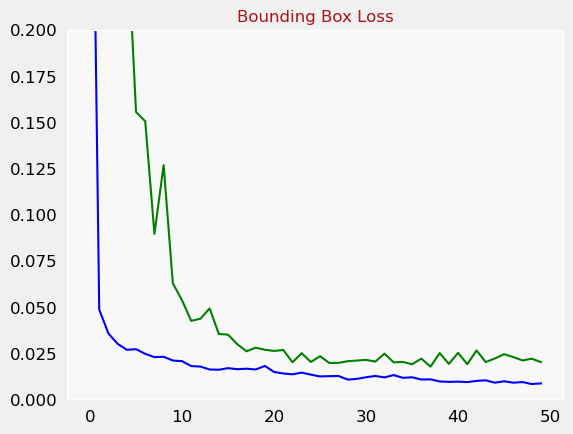

In [23]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)


### Evaluate performance using IoU

I can see how well my model predicts bounding boxes on the validation set by calculating the Intersection-over-union (IoU) score for each image.

- `intersection_over_union()` is the function for the IoU calculation.
- I on the validation set of images.
- I apply the `intersection_over_union` on these predicted bounding boxes.

In [24]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images.astype('float32'))


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

2025-08-19 11:30:58.469958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step
Number of predictions where iou > threshold(0.5): 205
Number of predictions where iou < threshold(0.5): 295



## Visualize Predictions

Lastly, I plot the predicted and ground truth bounding boxes for a random set of images


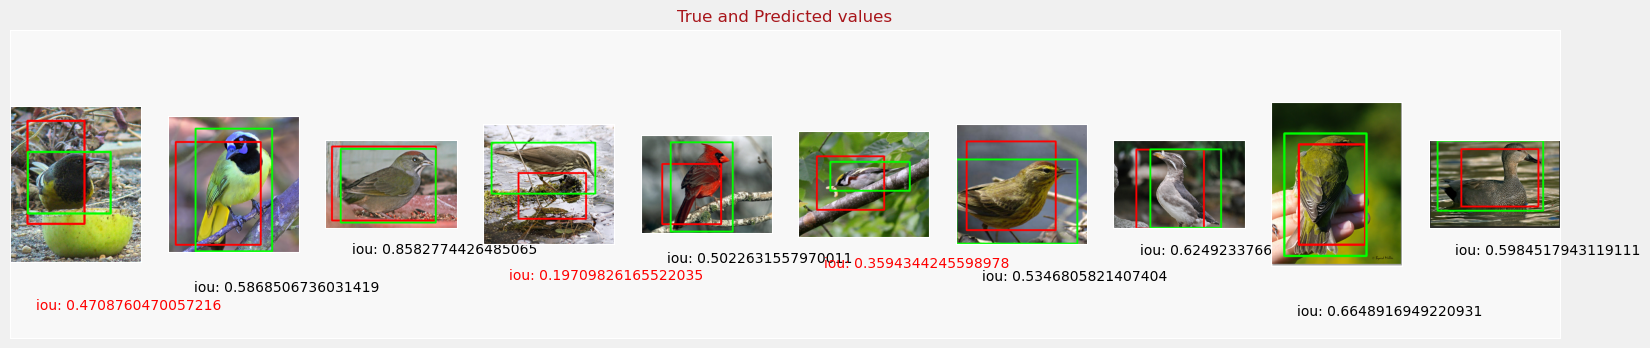

In [37]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)